In [1]:
import torch

In [2]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

### Zachary's karate club network
- This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club.
- Here, we are interested in detecting communities that arise from the member's interaction.

In [3]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [4]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


### Note
- train_mask, which describes for which nodes we already know their community assigments.
- In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

In [7]:
edge_index = data.edge_index
print(edge_index)  # This representation is known as the COO format (coordinate format)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

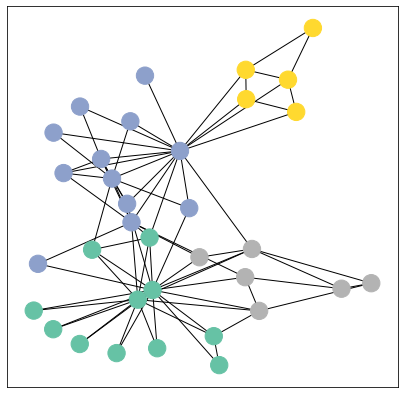

In [8]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

### Implementing Graph Neural Networks

In [10]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


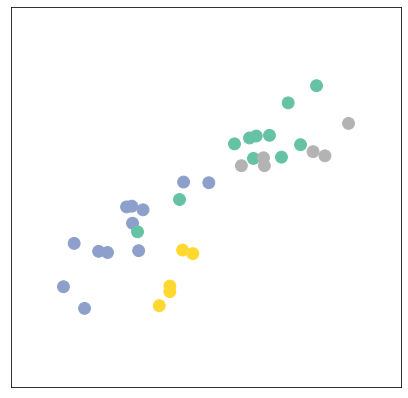

In [14]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

### Note
- Even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph. 
- Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized completely at random and we have not yet performed any training so far! 
- This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

In [19]:
print(_) # _ is self.classifier(h), but what is the meaning of negative values
print(h)

tensor([[-0.5967, -0.3627,  0.2102, -0.6589],
        [-0.6052, -0.3653,  0.2181, -0.6615],
        [-0.6084, -0.3650,  0.2185, -0.6609],
        [-0.5827, -0.3609,  0.2022, -0.6576],
        [-0.6220, -0.3622,  0.2173, -0.6567],
        [-0.6141, -0.3602,  0.2106, -0.6546],
        [-0.6143, -0.3605,  0.2113, -0.6550],
        [-0.5941, -0.3628,  0.2096, -0.6592],
        [-0.6374, -0.3684,  0.2345, -0.6632],
        [-0.6036, -0.3652,  0.2175, -0.6616],
        [-0.6190, -0.3625,  0.2169, -0.6572],
        [-0.5870, -0.3634,  0.2085, -0.6603],
        [-0.5883, -0.3596,  0.2013, -0.6556],
        [-0.6049, -0.3643,  0.2160, -0.6603],
        [-0.6569, -0.3680,  0.2400, -0.6615],
        [-0.6480, -0.3687,  0.2385, -0.6630],
        [-0.6106, -0.3594,  0.2079, -0.6539],
        [-0.6212, -0.3664,  0.2254, -0.6619],
        [-0.6440, -0.3687,  0.2373, -0.6632],
        [-0.6287, -0.3663,  0.2275, -0.6612],
        [-0.6509, -0.3674,  0.2368, -0.6611],
        [-0.6060, -0.3627,  0.2131

### Now
- Use semi-supervised or transductive learning procedure: train against one node per class, but are allowed to make use of the complete input graph data.
- Only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.<br><br>
- While we compute node embeddings for all of our nodes, we only make use of the training nodes for computing the loss
- Here, this is implemented by filtering the output of the classifier out and ground-truth labels data.y to only contain the nodes in the train_mask.

In [25]:
data.y[data.train_mask]

tensor([[-0.5967, -0.3627,  0.2102, -0.6589],
        [-0.6220, -0.3622,  0.2173, -0.6567],
        [-0.6374, -0.3684,  0.2345, -0.6632],
        [-0.6456, -0.3670,  0.2343, -0.6610]], grad_fn=<IndexBackward>)

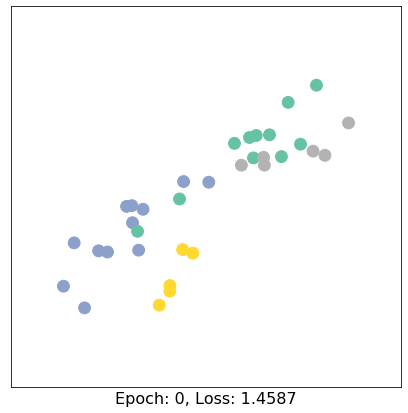

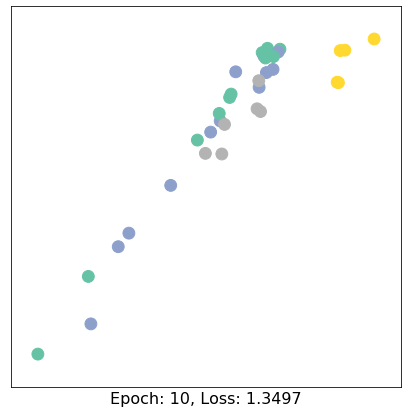

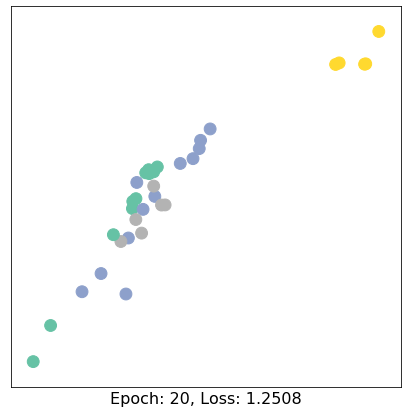

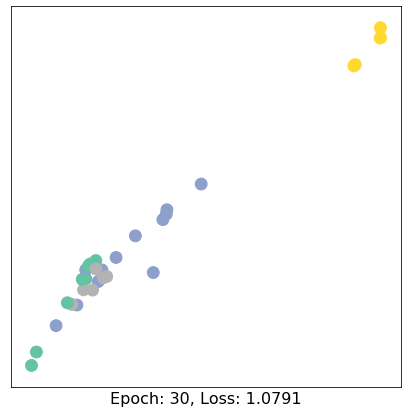

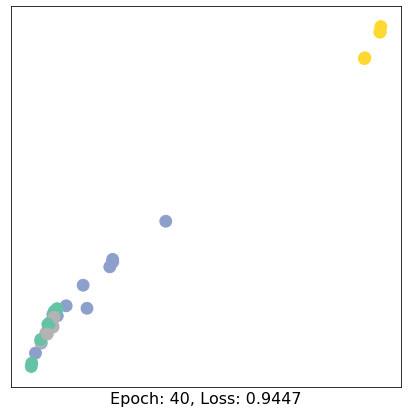

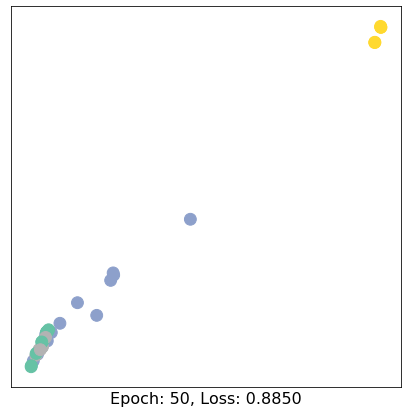

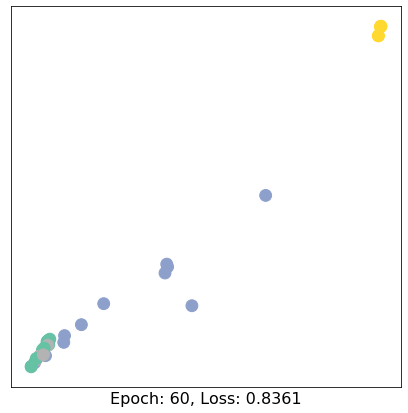

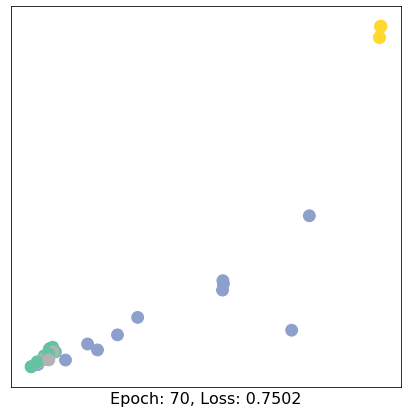

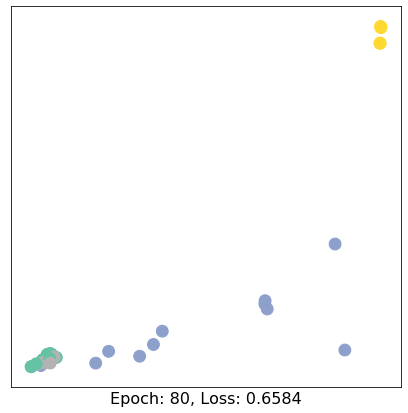

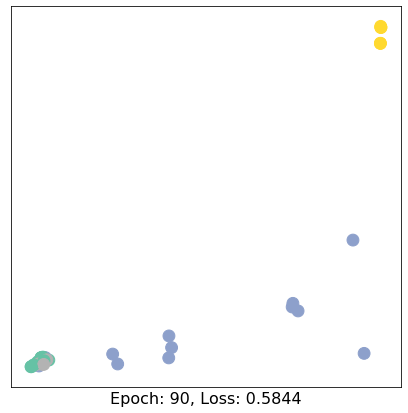

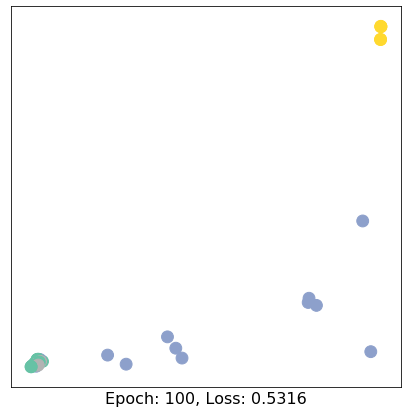

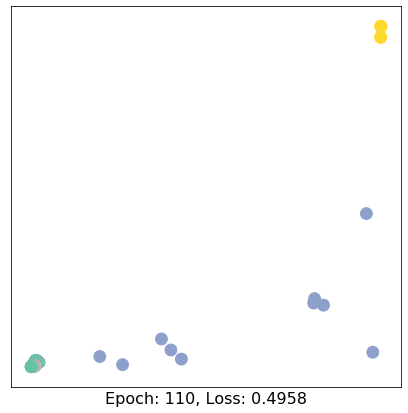

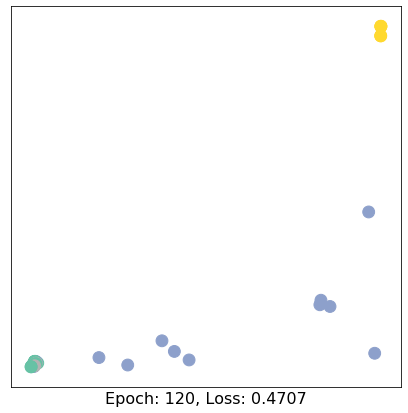

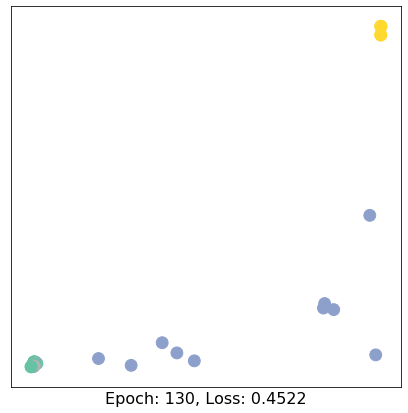

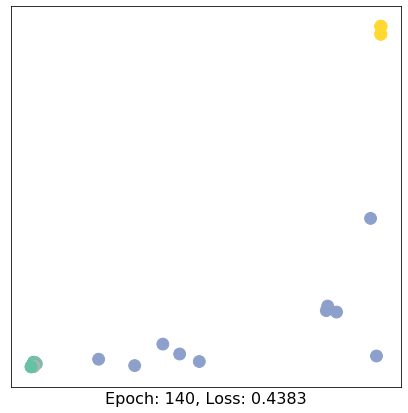

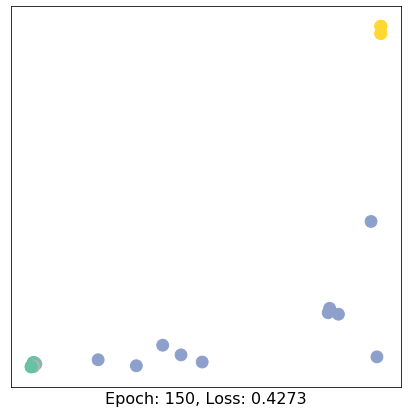

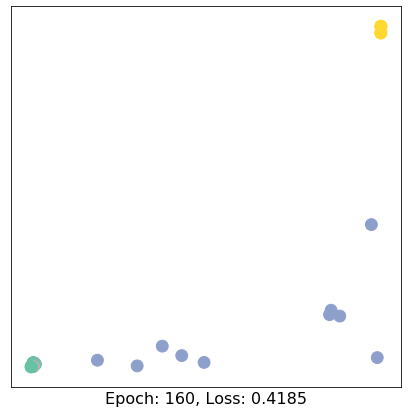

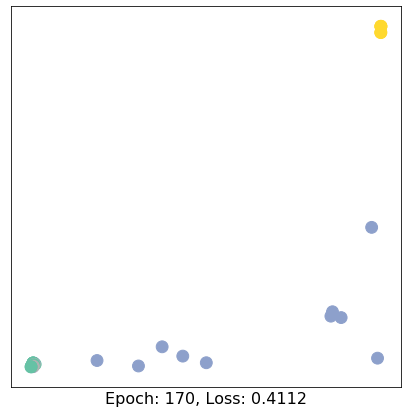

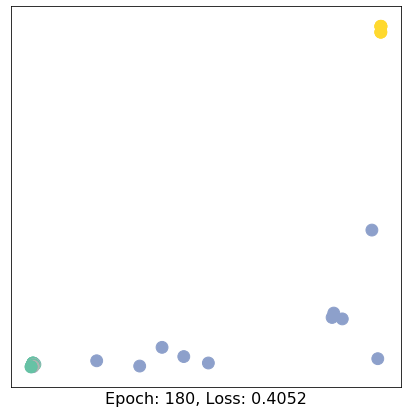

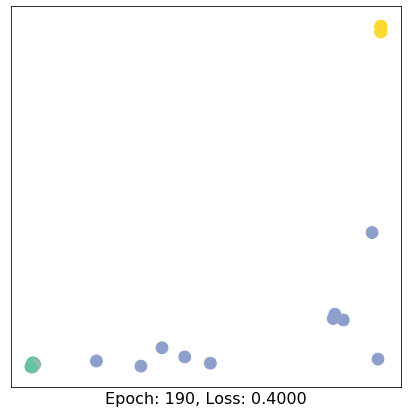

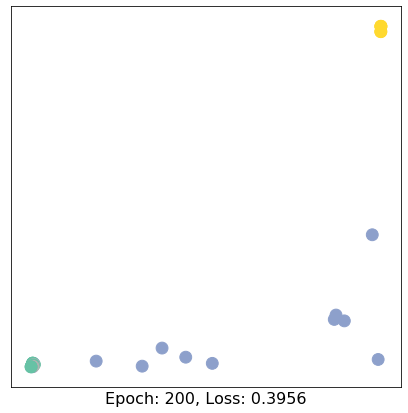

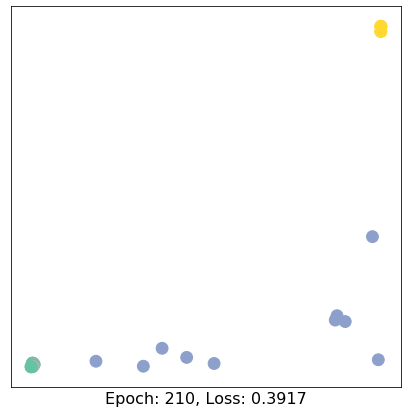

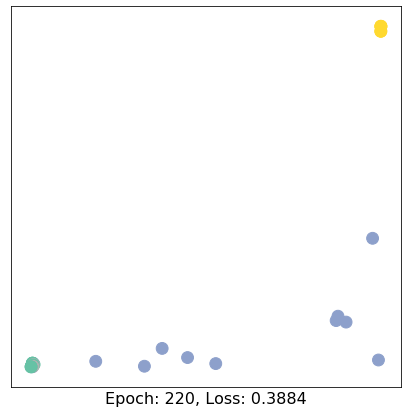

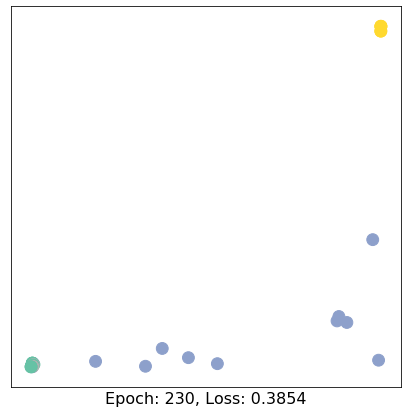

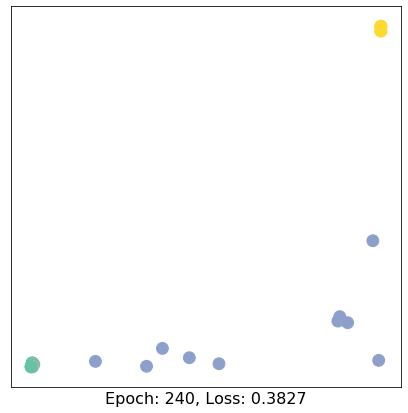

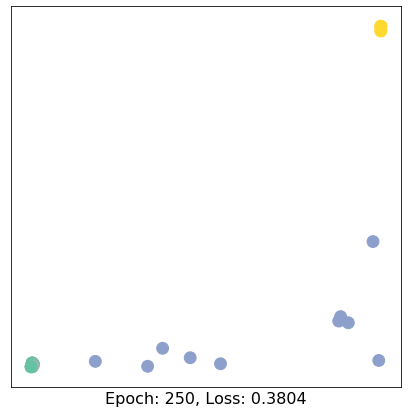

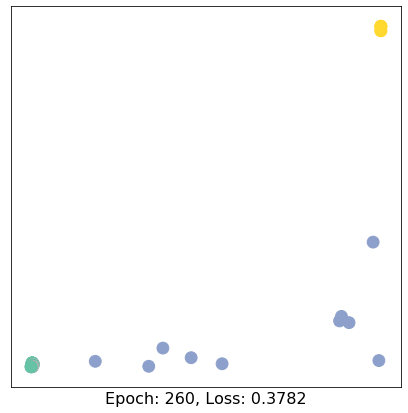

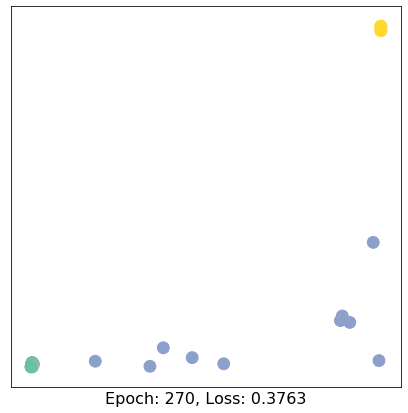

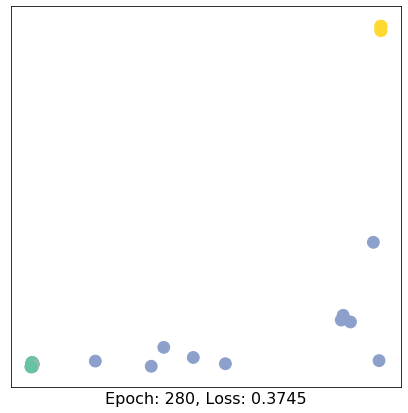

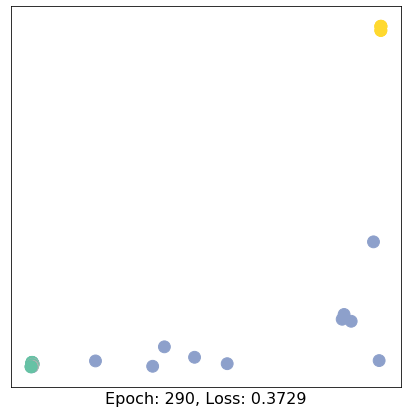

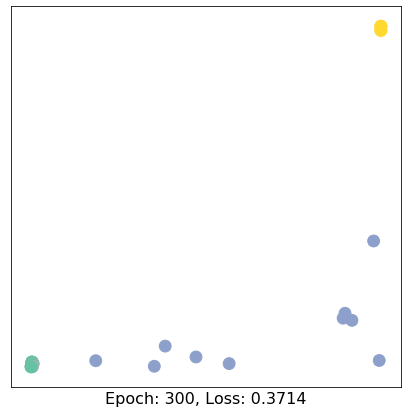

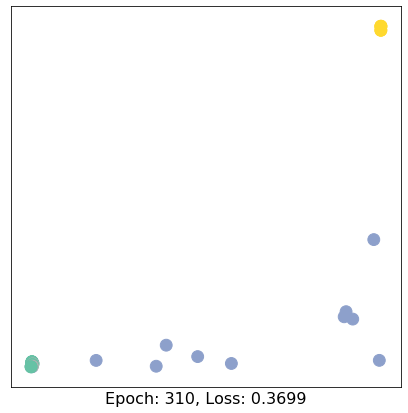

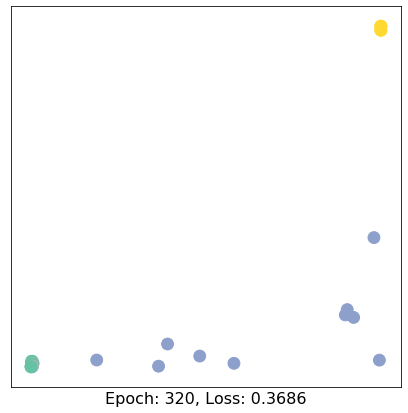

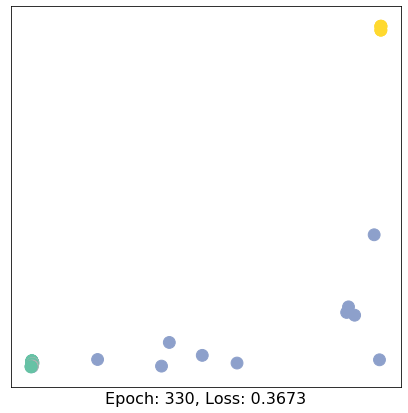

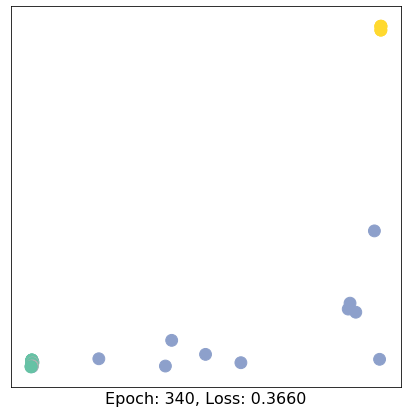

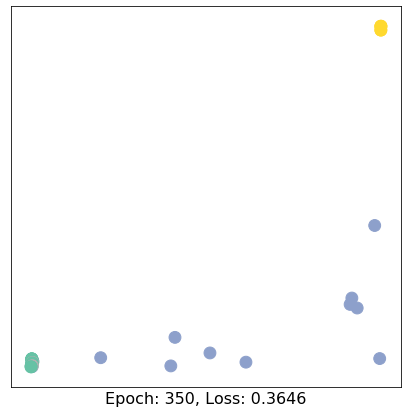

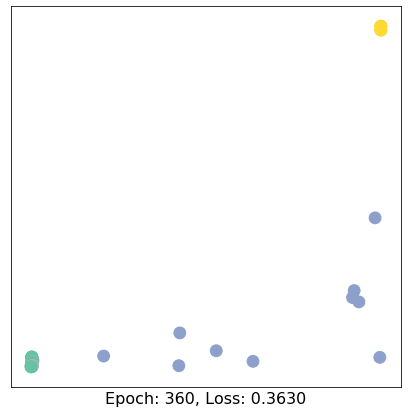

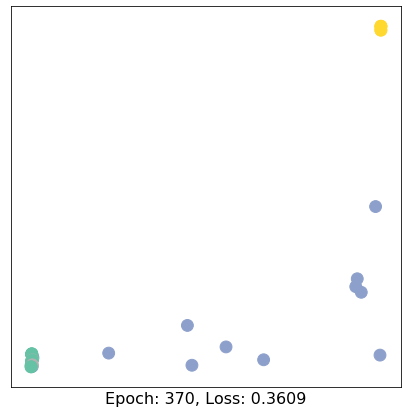

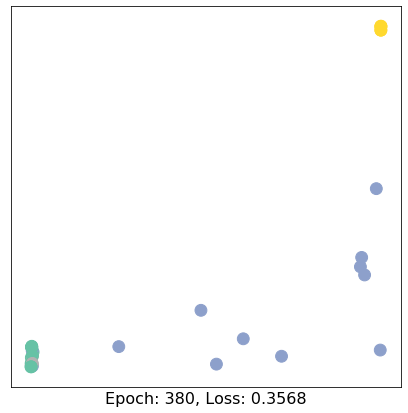

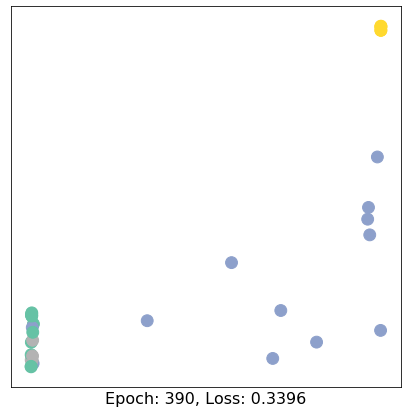

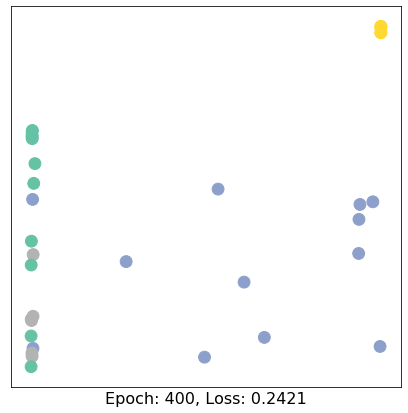

In [29]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

3-layer GCN model manages to linearly separating the communities and classifying most of the nodes correctly.